In [1]:
import pandas as pd
import numpy as np

### Importar bases de datos:

En esta sección se importan las librerías necesarias para el análisis de datos, visualización geoespacial y modelado estadístico. Posteriormente, se cargan las bases de datos con información de prestadores, sedes, municipios, población y geometría territorial.

| **Fuente** | **Descripción** | **Contenido Principal** | **Entidad Responsable** | **Fuente** |
|------------|-----------------|-------------------------|-------------------------|------------|
| **1. Prestadores** | Registro de prestadores de servicios de salud habilitados en Colombia. | Información sobre prestadores habilitados, incluyendo datos como nombre, tipo de prestador, naturaleza jurídica, y ubicación por departamento y municipio. | Ministerio de Salud y Protección Social | REPS
| **2. Sedes** | Registro de sedes de los prestadores de servicios de salud. | Detalles de las sedes de los prestadores, incluyendo dirección, municipio, departamento, y características de la sede. | Ministerio de Salud y Protección Social |REPS
| **3. Servicios** | Información sobre los servicios habilitados en las sedes de los prestadores. | Datos sobre los servicios ofrecidos por cada sede, incluyendo nivel de complejidad (baja, media, alta) y modalidades de atención (ambulatoria, hospitalaria, domiciliaria, unidad móvil, extramural). | Ministerio de Salud y Protección Social | REPS
| **4. Municipios** | Información geográfica y demográfica de los municipios de Colombia. | Datos sobre códigos DANE, nombres de departamentos y municipios, superficie, población total, porcentaje de ruralidad, y región. | Departamento Administrativo Nacional de Estadística (DANE) | PRUEBA


In [130]:
# Leer el archivo Excel, ajusta el nombre si es diferente
municipios = pd.read_csv("Copia de Municipios.csv", encoding = 'latin1', sep = ';',
    dtype={"DP": str, "MPIO": str}  # Importar DP y MPIO como string
)

In [3]:
sedes = pd.read_csv("Sedes.csv", 
                 encoding='latin1',
                 sep=';',
                 index_col = False,
                 on_bad_lines='skip',
                 quoting=3,
                 engine='python',        
                 dtype=str
)

C:\Users\brann\AppData\Local\Temp\ipykernel_16852\2559680828.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  sedes = pd.read_csv("Sedes.csv",


In [4]:
prestadores = pd.read_csv("Prestadores.csv", 
                 encoding='latin1',
                 sep=';',
                 index_col = False,
                 on_bad_lines='skip',
                 quoting=3,
                 engine='python',        
                 dtype=str
)

C:\Users\brann\AppData\Local\Temp\ipykernel_16852\715686913.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  prestadores = pd.read_csv("Prestadores.csv",


In [5]:
servicios = pd.read_csv("servicios.csv", 
                 encoding='latin1',
                 sep=';',
                 index_col = False,
                 on_bad_lines='skip',
                 quoting=3,
                 engine='python',        
                 dtype=str
)

C:\Users\brann\AppData\Local\Temp\ipykernel_16852\789941462.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  servicios = pd.read_csv("servicios.csv",


### Exploración y limpieza

Se realiza una exploración inicial para identificar la estructura de las variables, valores nulos, y posibles inconsistencias. Se estandarizan nombres de columnas y municipios, se convierten variables categóricas a formato numérico cuando es necesario, y se agregan los datos por municipio para consolidar indicadores a nivel territorial.


In [6]:
import re

def limpiar_texto(texto):
    # Reemplaza caracteres que no sean letras, espacios o acentos por nada
    texto_limpio = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]", "", texto)
    return texto_limpio.strip()

for col in ['Departamento', 'Municipio']:
    municipios[col] = municipios[col].astype(str).apply(limpiar_texto).str.title()
    
for col in ["Superficie", "PopTot", "Rural"]:
    municipios[col] = (
        municipios[col]
        .astype(str)
        .str.replace(r"[^\d\.,]", "", regex=True)  # Eliminar símbolos extraños
        .str.replace(",", ".", regex=False)        # Reemplazar coma por punto decimal
    )
    municipios[col] = pd.to_numeric(municipios[col], errors="coerce")

municipios.columns = ['cod_departamento','departamento','cod_municipio','municipio', 
                      'superficie_km2', 'poblacion_total','porcentaje_ruralidad','region']

print(municipios.head())
print(municipios.dtypes)

  cod_departamento departamento cod_municipio   municipio  superficie_km2  \
0                5    Antioquia          5001    Medellín      350.666623   
1                5    Antioquia          5002   Abejorral      497.566213   
2                5    Antioquia          5004    Abriaquí      287.641603   
3                5    Antioquia          5021  Alejandría      119.467683   
4                5    Antioquia          5030       Amagá       89.245903   

   poblacion_total  porcentaje_ruralidad                region  
0          2634570                   1.6  Región Eje Cafetero   
1            21622                  56.7  Región Eje Cafetero   
2             2872                  64.2  Región Eje Cafetero   
3             4989                  40.7  Región Eje Cafetero   
4            32628                  47.4  Región Eje Cafetero   
cod_departamento         object
departamento             object
cod_municipio            object
municipio                object
superficie_km2     

In [7]:
#se eliminan duplicados y vacios
df_dict = {
    'prestadores': prestadores,
    'sedes': sedes,
    'servicios': servicios,
    'municipios': municipios
}

# Limpieza general
for name, df in df_dict.items():
    # Estandarizar nombres de columnas
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_", regex=False)

    # Eliminar duplicados
    df.drop_duplicates(inplace=True)

    # Reemplazar valores nulos o vacíos
    df.replace(['', ' ', 'NA', 'n/a', 'NaN'], pd.NA, inplace=True)

    # Asignar nuevamente al diccionario (opcional, si luego quieres exportar o seguir usando)
    df_dict[name] = df

# Extraer los DataFrames limpios si los necesitas luego
prestadores = df_dict['prestadores']
sedes = df_dict['sedes']
servicios = df_dict['servicios']
municipios = df_dict['municipios']

C:\Users\brann\AppData\Local\Temp\ipykernel_16852\1110873079.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(['', ' ', 'NA', 'n/a', 'NaN'], pd.NA, inplace=True)


In [8]:
def resumen_estructura(df, nombre):
    resumen = {
        "Archivo": nombre,
        "Columnas": df.shape[1],
        "Registros": df.shape[0],
        "Promedio valores únicos por columna": int(df.nunique().mean()),
        "Máx. valores únicos en una columna": df.nunique().max(),
        "Mín. valores únicos en una columna": df.nunique().min()
    }
    return resumen

# Crear resúmenes
resumenes = []
resumenes.append(resumen_estructura(prestadores, "Prestadores"))
resumenes.append(resumen_estructura(sedes, "Sedes"))
resumenes.append(resumen_estructura(servicios, "Servicios"))

# Convertir a DataFrame para mostrar como tabla
resumen_general = pd.DataFrame(resumenes)
print("\n📊 Resumen estructural de las bases:")
print(resumen_general)



📊 Resumen estructural de las bases:
       Archivo  Columnas  Registros  Promedio valores únicos por columna  \
0  Prestadores        36      59421                                12529   
1        Sedes        47      74775                                12310   
2    Servicios        93     228191                                 8167   

   Máx. valores únicos en una columna  Mín. valores únicos en una columna  
0                               59421                                   0  
1                               68743                                   2  
2                              223164                                   2  


In [10]:
prestadores.columns

Index(['depa_nombre', 'muni_nombre', 'codigo_habilitacion', 'nombre_prestador',
       'tido_codigo', 'nits_nit', 'razon_social', 'clpr_codigo', 'clpr_nombre',
       'ese', 'direccion', 'telefono', 'fax', 'email', 'gerente', 'nivel',
       'caracter', 'habilitado', 'fecha_radicacion', 'fecha_vencimiento',
       'fecha_cierre', 'dv', 'clase_persona', 'naju_codigo', 'naju_nombre',
       'numero_sede_principal', 'fecha_corte_reps', 'telefono_adicional',
       'email_adicional', 'rep_legal', 'municipio_pdet', 'municipio_zomac',
       'municipio_pnis', 'municipio_pnsr_antes_2023', 'municipio_pnsr_2023',
       'municipio_pnsr_2024'],
      dtype='object')

In [11]:
sedes.columns

Index(['departamento', 'municipio', 'codigo_prestador', 'nombre_prestador',
       'codigo_habilitacion', 'numero_sede', 'nombre', 'gerente', 'tipo_zona',
       'direccion', 'barrio', 'cepo_codigo', 'centro_poblado', 'telefono',
       'fax', 'email', 'fecha_apertura', 'fecha_cierre', 'nits_nit', 'dv',
       'clase_persona', 'naju_codigo', 'naturaleza', 'clpr_codigo',
       'clase_prestador', 'ese', 'nivel', 'caracter', 'sede_principal',
       'habilitado', 'numero_sede_principal', 'horario_lunes',
       'horario_martes', 'horario_miercoles', 'horario_jueves',
       'horario_viernes', 'horario_sabado', 'horario_domingo',
       'fecha_corte_reps', 'telefono_adicional', 'email_adicional',
       'municipio_pdet', 'municipio_zomac', 'municipio_pnis',
       'municipio_pnsr_antes_2023', 'municipio_pnsr_2023',
       'municipio_pnsr_2024'],
      dtype='object')

In [12]:
servicios.columns

Index(['depa_nombre', 'muni_nombre', 'habi_codigo_habilitacion',
       'codigo_habilitacion', 'numero_sede', 'sede_nombre', 'direccion',
       'telefono', 'email', 'nits_nit', 'dv', 'clase_persona', 'naju_codigo',
       'naju_nombre', 'clpr_codigo', 'clpr_nombre', 'ese', 'nivel', 'caracter',
       'habilitado', 'grse_codigo', 'grse_nombre', 'serv_codigo',
       'serv_nombre', 'ambulatorio', 'hospitalario', 'unidad_movil',
       'domiciliario', 'otras_extramural', 'centro_referencia',
       'institucion_remisora', 'complejidad_baja', 'complejidad_media',
       'complejidad_alta', 'fecha_apertura', 'fecha_cierre',
       'numero_distintivo', 'numero_sede_principal',
       'observaciones_serv_res3100_2019', 'fecha_corte_reps', 'nombre',
       'horario_lunes', 'horario_martes', 'horario_miercoles',
       'horario_jueves', 'horario_viernes', 'horario_sabado',
       'horario_domingo', 'modalidad_intramural', 'modalidad_extramural',
       'modalidad_unidad_movil', 'modalidad_domi

In [13]:
municipios.columns

Index(['cod_departamento', 'departamento', 'cod_municipio', 'municipio',
       'superficie_km2', 'poblacion_total', 'porcentaje_ruralidad', 'region'],
      dtype='object')

# Columnas útiles por base de datos

## 1. Municipios (base de referencia para indicadores de cobertura)
| Propósito           | Columnas                                                  |
|---------------------|-----------------------------------------------------------|
| Llave geográfica    | municipio (nombre), cod_dane (recomendado usar código DANE) |
| Datos poblacionales | poblacion_total, superficie, porcentaje_ruralidad          |
| Agrupación regional | region                                                    |

Esta base nos da la población y superficie para calcular tasas de cobertura (por 10.000 habitantes, por km²) y desagregar por zona rural/urbana o región.

---


| Propósito               | Columnas                                                    |
|-------------------------|-------------------------------------------------------------|
| Llave con sedes y servicios | cod_prestador, municipio, departamento                     |
| Identificación del prestador | nombre_prestador, razon_social, nit                         |
| Clasificación del prestador  | clase_prestador, nivel, caracter, ese                        |
| Información de habilitación  | habilitado, fecha_radicacion, fecha_cierre                   |
| Contexto territorial         | Municipio PDET, Municipio ZOMAC, etc. (útiles para análisis diferenciado por zonas especiales) |

Esta base permite identificar qué tipo de instituciones prestan servicios y cuántas hay por territorio. El cod_prestador es clave para unir con sedes y servicios.

---

## 3. Sedes
| Propósito               | Columnas                                                    |
|-------------------------|-------------------------------------------------------------|
| Llave con servicios y prestadores | codigo_habilitacion, numero_sede, codigo_prestador, municipio |
| Información geográfica   | departamento, municipio, tipo_zona, direccion, barrio, centro_poblado |
| Clasificación           | nivel, caracter, sede_principal, habilitado                   |
| Horarios (opcional)     | horario_lunes a horario_domingo                               |

 Permite contar infraestructura física disponible y georreferenciar sedes. También permite saber si están en zonas rurales/urbanas.

---

## 4. Servicios
| Propósito               | Columnas                                                    |
|-------------------------|-------------------------------------------------------------|
| Llave con sedes y prestadores | codigo_habilitacion, numero_sede, nits_nit (para unir con prestadores) |
| Geografía y sede        | muni_nombre, depa_nombre, sede_nombre                        |
| Tipo de servicio        | serv_codigo, serv_nombre, grse_codigo, grse_nombre          |
| Modalidad               | ambulatorio, hospitalario, domiciliario, unidad_movil, etc. |
| Complejidad             | complejidad_baja, complejidad_media, complejidad_alta       |
| Especificidades         | especificidad_salud_mental, especificidad_atencion_paciente_quemado, etc. |

Esta base es central para el análisis de oferta de servicios, por modalidad, complejidad y tipo. Es clave para calcular indicadores como:

- Total de servicios por municipio
- Servicios con alta complejidad
- Servicios de salud mental, oncológicos, trasplantes, etc.
- Comparación con población municipal

### Consultas SQL

In [18]:
import sqlite3

In [19]:
conn = sqlite3.connect("mi_base_de_datos.db")

In [20]:
prestadores.to_sql('prestadores', conn, index=False)
sedes.to_sql('sedes', conn, index=False)
servicios.to_sql('servicios', conn, index=False)
municipios.to_sql('municipios', conn, index=False)

1118

In [21]:
consulta_prestadores = """
SELECT 
    depa_nombre,
    muni_nombre,
    COUNT(DISTINCT codigo_habilitacion) AS numero_prestadores
FROM prestadores
WHERE habilitado = 'SI'
GROUP BY depa_nombre, muni_nombre
ORDER BY numero_prestadores DESC;
"""
df_prestadores_mpio = pd.read_sql_query(consulta_prestadores, conn)
consulta_prestadores

"\nSELECT \n    depa_nombre,\n    muni_nombre,\n    COUNT(DISTINCT codigo_habilitacion) AS numero_prestadores\nFROM prestadores\nWHERE habilitado = 'SI'\nGROUP BY depa_nombre, muni_nombre\nORDER BY numero_prestadores DESC;\n"

In [22]:
df_prestadores_mpio

,depa_nombre,muni_nombre,numero_prestadores
0,Bogotá D.C,BOGOTÁ,13750
1,Antioquia,MEDELLÍN,7382
2,Cali,CALI,4079
3,Barranquilla,BARRANQUILLA,1876
4,Risaralda,PEREIRA,1319
...,...,...,...
976,Valle del cauca,EL ÁGUILA,1
977,Valle del cauca,OBANDO,1
978,Valle del cauca,ULLOA,1
979,Valle del cauca,VERSALLES,1


In [23]:
consulta_sedes = """
SELECT 
    departamento,
    municipio,
    COUNT(DISTINCT codigo_habilitacion) AS numero_sedes
FROM sedes
GROUP BY municipio
ORDER BY numero_sedes DESC;

"""
df_sedes_mpio = pd.read_sql_query(consulta_sedes, conn)

In [24]:
df_sedes_mpio

,departamento,municipio,numero_sedes
0,Bogotá D.C,BOGOTÁ,13758
1,Antioquia,MEDELLÍN,7740
2,Cali,CALI,4086
3,Barranquilla,BARRANQUILLA,1879
4,Santander,BUCARAMANGA,1362
...,...,...,...
1028,Boyacá,ALMEIDA,1
1029,Cauca,ALMAGUER,1
1030,Santander,AGUADA,1
1031,Antioquia,ABRIAQUÍ,1


### Procesamiento de datos

En esta etapa se construyen indicadores de cobertura y densidad, como prestadores por cada 100 mil habitantes, sedes por kilómetro cuadrado, y modalidad de atención por cada 100 mil habitantes. Estos indicadores permiten una mejor comparación entre territorios heterogéneos en población y superficie.

In [29]:
# Merge Prestadores con Sedes (por código_habilitación)
merged = pd.merge(sedes, prestadores[['codigo_habilitacion', 'muni_nombre']], 
                    on='codigo_habilitacion', suffixes=('', '_prestador'))

# Merge con Servicios (por código_habilitación y número_sede)
merged_full = pd.merge(merged, servicios, 
                       on=['codigo_habilitacion', 'numero_sede'], suffixes=('', '_servicio'))

In [30]:
# Lista de columnas binarias
cols_binarias = [
    'complejidad_alta', 'complejidad_media',
    'ambulatorio', 'hospitalario', 'unidad_movil',
    'domiciliario', 'otras_extramural'
]

# Convertir "SI" → 1 y "NO"/otros → 0
for col in cols_binarias:
    merged_full[col] = merged_full[col].str.upper().map({'SI': 1, 'NO': 0}).fillna(0).astype(int)

In [31]:
# Aseguramos que las columnas de complejidad sean binarias (0 o 1)
for col in ['complejidad_alta', 'complejidad_media', 'ambulatorio', 'hospitalario', 
            'unidad_movil', 'domiciliario', 'otras_extramural']:
    merged_full[col] = merged_full[col].fillna(0).astype(int)

# Agrupación por municipio
resumen = merged_full.groupby(['depa_nombre','muni_nombre']).agg(
    num_prestadores=('codigo_habilitacion', pd.Series.nunique),
    num_sedes=('numero_sede', pd.Series.nunique),
    sedes_complejidad_alta=('complejidad_alta', 'sum'),
    sedes_complejidad_media=('complejidad_media', 'sum'),
    sedes_ambulatorio=('ambulatorio', 'sum'),
    sedes_hospitalario=('hospitalario', 'sum'),
    sedes_unidad_movil=('unidad_movil', 'sum'),
    sedes_domiciliario=('domiciliario', 'sum'),
    sedes_otras_extramural=('otras_extramural', 'sum')
).reset_index()

Aca vamos a estandarizar nombres para poder unir con datos demograficos y calcular tasas

In [32]:
resumen['muni_nombre'] = resumen['muni_nombre'].str.title()

In [33]:
resumen['muni_nombre'] = resumen['muni_nombre'].str.strip().str.title()
resumen['depa_nombre'] = resumen['depa_nombre'].str.strip().str.title()

municipios['municipio'] = municipios['municipio'].str.strip().str.title()
municipios['departamento'] = municipios['departamento'].str.strip().str.title()

In [34]:
resumen_final = pd.merge(
    resumen,
    municipios,
    left_on=['muni_nombre', 'depa_nombre'],
    right_on=['municipio', 'departamento'],
    how='inner'  # o 'inner' si solo quieres los que coinciden
)


In [35]:
def calcular_indicadores(df, base_poblacional='poblacion_total', base_superficie='superficie_km2'):
    indicadores = {
        'num_prestadores': ('prestadores_por_100k', base_poblacional, 100000),
        'num_sedes': ('sedes_por_km2', base_superficie, 1),
        'sedes_complejidad_alta': ('alta_complejidad_por_100k', base_poblacional, 100000),
        'sedes_complejidad_media': ('media_complejidad_por_100k', base_poblacional, 100000),
        'sedes_ambulatorio': ('ambulatorio_por_100k', base_poblacional, 100000),
        'sedes_hospitalario': ('hospitalario_por_100k', base_poblacional, 100000),
        'sedes_unidad_movil': ('unidad_movil_por_100k', base_poblacional, 100000),
        'sedes_domiciliario': ('domiciliario_por_100k', base_poblacional, 100000),
        'sedes_otras_extramural': ('otras_extramural_por_100k', base_poblacional, 100000)
    }

    for col_origen, (col_destino, col_base, factor) in indicadores.items():
        df[col_destino] = (df[col_origen] / df[col_base].replace(0, np.nan)) * factor

    return df


In [36]:
indicadores =  calcular_indicadores(resumen_final)

In [54]:
indicadores

,depa_nombre,muni_nombre,num_prestadores,num_sedes,sedes_complejidad_alta,sedes_complejidad_media,sedes_ambulatorio,sedes_hospitalario,sedes_unidad_movil,sedes_domiciliario,...,region,prestadores_por_100k,sedes_por_km2,alta_complejidad_por_100k,media_complejidad_por_100k,ambulatorio_por_100k,hospitalario_por_100k,unidad_movil_por_100k,domiciliario_por_100k,otras_extramural_por_100k
0,Amazonas,Leticia,55,2,0,50,97,25,6,6,...,Región Centro Sur,98.759225,0.000350,0.000000,89.781114,174.175360,44.890557,10.773734,10.773734,10.773734
1,Antioquia,Abejorral,13,4,0,1,22,2,0,0,...,Región Eje Cafetero,60.123948,0.008039,0.000000,4.624919,101.748219,9.249838,0.000000,0.000000,0.000000
2,Antioquia,Alejandría,1,1,0,0,6,3,1,2,...,Región Eje Cafetero,20.044097,0.008370,0.000000,0.000000,120.264582,60.132291,20.044097,40.088194,0.000000
3,Antioquia,Amagá,22,1,0,1,14,1,1,1,...,Región Eje Cafetero,67.426750,0.011205,0.000000,3.064852,42.907932,3.064852,3.064852,3.064852,3.064852
4,Antioquia,Amalfi,15,2,0,1,10,3,0,2,...,Región Eje Cafetero,53.458783,0.001537,0.000000,3.563919,35.639189,10.691757,0.000000,7.127838,7.127838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,Valle Del Cauca,Yumbo,64,11,1,50,136,2,3,6,...,Región Pacífico,58.772212,0.044395,0.918316,45.915790,124.890950,1.836632,2.754947,5.509895,0.000000
785,Valle Del Cauca,Zarzal,29,6,0,22,61,6,0,6,...,Región Pacífico,67.048923,0.016398,0.000000,50.864700,141.033941,13.872191,0.000000,13.872191,0.000000
786,Vaupés,Mitú,7,32,0,15,28,6,1,0,...,Región Llano,19.580967,0.001989,0.000000,41.959216,78.323869,16.783686,2.797281,0.000000,11.189124
787,Vichada,Cumaribo,4,1,0,0,12,0,0,6,...,Región Llano,4.525296,0.000016,0.000000,0.000000,13.575889,0.000000,0.000000,6.787945,9.050593


### Visualizaciones

Se generan visualizaciones para describir la distribución de los servicios de salud en el territorio. Incluyen mapas de calor, diagramas de barras por región, y comparaciones entre departamentos. Estas gráficas permiten identificar brechas y patrones territoriales relevantes.

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
gdf = gpd.read_file("C:/Users/brann/Documents/PRUEBA IELTS/MGN2022_MPIO_POLITICO/MGN_MPIO_POLITICO.shp")

In [94]:
gdf["MPIO_CDPMP"] = gdf["MPIO_CDPMP"].astype(str).str.zfill(5)
indicadores["cod_municipio"] = indicadores["cod_municipio"].astype(str).str.zfill(5)

In [95]:
gdf1 = indicadores.merge(gdf, left_on="cod_municipio", right_on="MPIO_CDPMP", how = 'right')

In [96]:
gdf2 = gpd.GeoDataFrame(gdf1, geometry='geometry', crs="EPSG:4326")

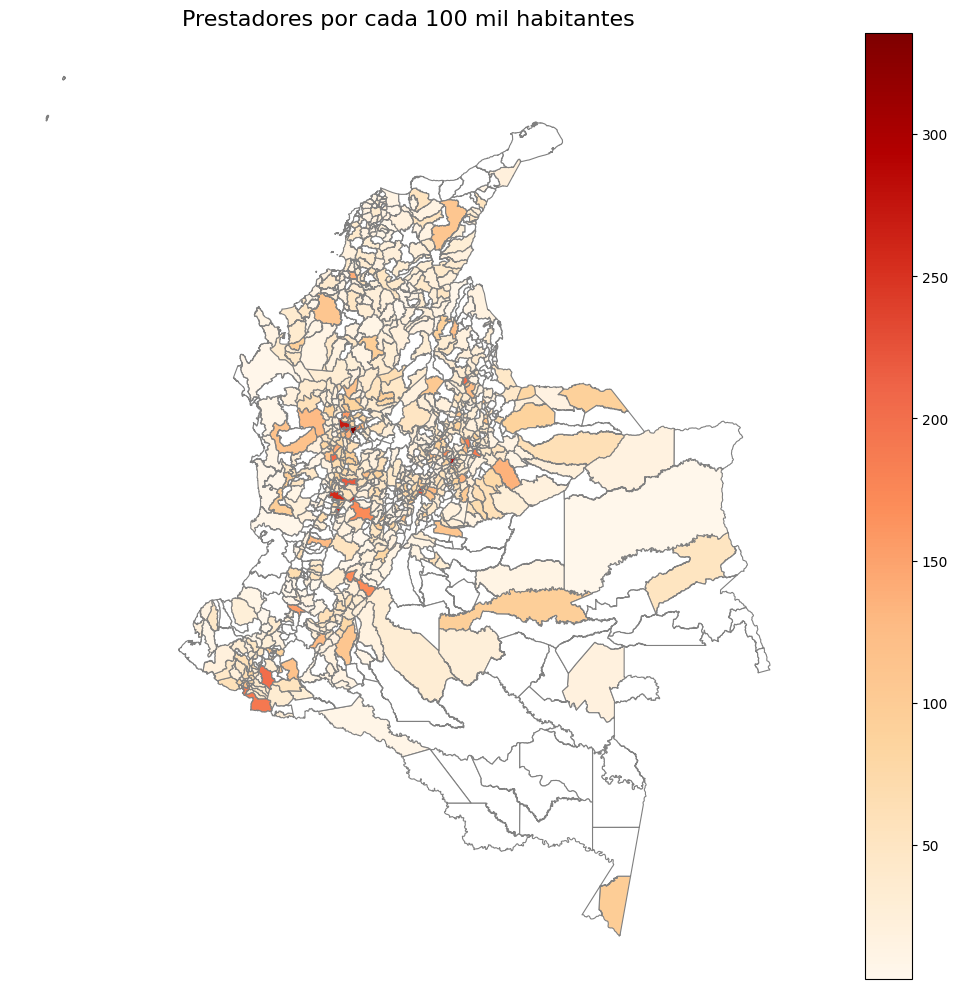

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf2.plot(
    column="prestadores_por_100k",
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    legend=True,
    edgecolor="gray",
    missing_kwds={
        "color": "white",           # Color para los NaN
        "edgecolor": "gray",        # Contorno de los polígonos con NaN
    }
)
ax.set_title("Prestadores por cada 100 mil habitantes", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.save
plt.show()

In [63]:
indicadores.columns

Index(['depa_nombre', 'muni_nombre', 'num_prestadores', 'num_sedes',
       'sedes_complejidad_alta', 'sedes_complejidad_media',
       'sedes_ambulatorio', 'sedes_hospitalario', 'sedes_unidad_movil',
       'sedes_domiciliario', 'sedes_otras_extramural', 'cod_departamento',
       'departamento', 'cod_municipio', 'municipio', 'superficie_km2',
       'poblacion_total', 'porcentaje_ruralidad', 'region',
       'prestadores_por_100k', 'sedes_por_km2', 'alta_complejidad_por_100k',
       'media_complejidad_por_100k', 'ambulatorio_por_100k',
       'hospitalario_por_100k', 'unidad_movil_por_100k',
       'domiciliario_por_100k', 'otras_extramural_por_100k'],
      dtype='object')

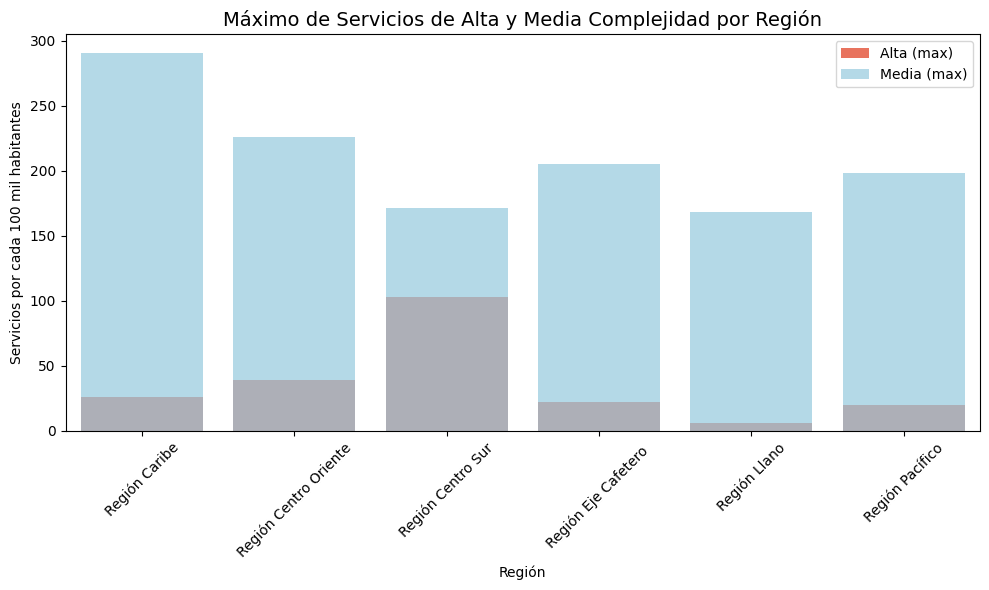

In [64]:
agg = indicadores.groupby("region")[["alta_complejidad_por_100k", "media_complejidad_por_100k"]].agg(["min", "max"]).reset_index()
agg.columns = ["region", "alta_min", "alta_max", "media_min", "media_max"]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=agg, x="region", y="alta_max", color="tomato", label="Alta (max)")
sns.barplot(data=agg, x="region", y="media_max", color="skyblue", alpha=0.7, label="Media (max)")
ax.set_title("Máximo de Servicios de Alta y Media Complejidad por Región", fontsize=14)
ax.set_ylabel("Servicios por cada 100 mil habitantes")
ax.set_xlabel("Región")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("barras_complejidad_por_region.png", dpi=300)

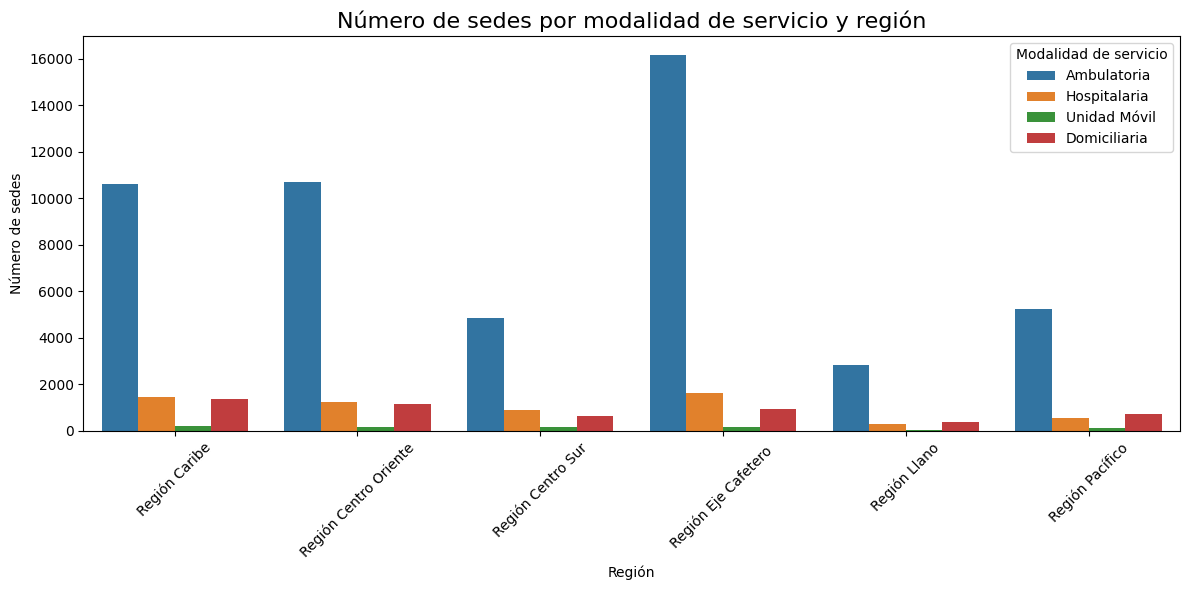

In [125]:
# Columnas de modalidad de servicio
modalidad_cols = [
    'sedes_ambulatorio',
    'sedes_hospitalario',
    'sedes_unidad_movil',
    'sedes_domiciliario'
]

# Agrupar por región
modalidad_region = indicadores.groupby('region')[modalidad_cols].sum().reset_index()

# Convertir a formato largo
modalidad_region_long = modalidad_region.melt(
    id_vars='region',
    value_vars=modalidad_cols,
    var_name='modalidad',
    value_name='cantidad'
)

# Renombrar las modalidades para presentación
modalidad_region_long['modalidad'] = modalidad_region_long['modalidad'].replace({
    'sedes_ambulatorio': 'Ambulatoria',
    'sedes_hospitalario': 'Hospitalaria',
    'sedes_unidad_movil': 'Unidad Móvil',
    'sedes_domiciliario': 'Domiciliaria'
})

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=modalidad_region_long,
    x='region', y='cantidad', hue='modalidad'
)
plt.title('Número de sedes por modalidad de servicio y región', fontsize=16)
plt.xlabel('Región')
plt.ylabel('Número de sedes')
plt.xticks(rotation=45)
plt.legend(title='Modalidad de servicio')
plt.tight_layout()
plt.show()


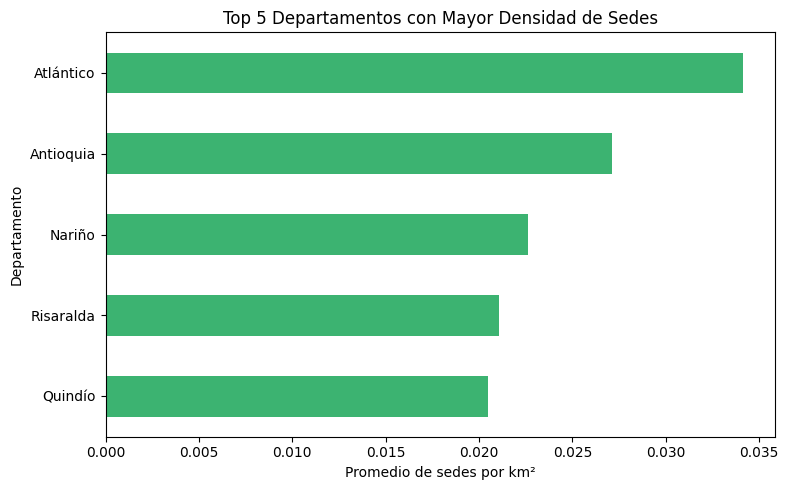

In [67]:
top5 = indicadores.groupby("depa_nombre")["sedes_por_km2"].mean().sort_values(ascending=False).head(5)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
top5.sort_values().plot(kind="barh", color="mediumseagreen", ax=ax)
ax.set_xlabel("Promedio de sedes por km²")
ax.set_ylabel("Departamento")
ax.set_title("Top 5 Departamentos con Mayor Densidad de Sedes")
plt.tight_layout()
plt.savefig("top5_sedes_por_km2.png", dpi=300)

### Regresión Lineal

Se estima un modelo de regresión lineal utilizando statsmodels para analizar la relación entre la cobertura de prestadores y variables explicativas como la densidad de sedes y la disponibilidad de servicios de alta complejidad. Se presenta un resumen estadístico con coeficientes, errores estándar y significancia, complementado con visualizaciones de los resultados.

In [103]:
import statsmodels.api as sm


In [110]:
indicadores.columns

Index(['depa_nombre', 'muni_nombre', 'num_prestadores', 'num_sedes',
       'sedes_complejidad_alta', 'sedes_complejidad_media',
       'sedes_ambulatorio', 'sedes_hospitalario', 'sedes_unidad_movil',
       'sedes_domiciliario', 'sedes_otras_extramural', 'cod_departamento',
       'departamento', 'cod_municipio', 'municipio', 'superficie_km2',
       'poblacion_total', 'porcentaje_ruralidad', 'region',
       'prestadores_por_100k', 'sedes_por_km2', 'alta_complejidad_por_100k',
       'media_complejidad_por_100k', 'ambulatorio_por_100k',
       'hospitalario_por_100k', 'unidad_movil_por_100k',
       'domiciliario_por_100k', 'otras_extramural_por_100k'],
      dtype='object')

In [126]:
# Variables
X = indicadores[['sedes_por_km2', 'media_complejidad_por_100k','hospitalario_por_100k','ambulatorio_por_100k']]
y = indicadores['prestadores_por_100k']

# Agregar constante para intercepto
X = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X).fit()

# Resumen en tabla
summary_df = model.summary2().tables[1].copy()
summary_df['Significancia'] = summary_df['P>|t|'].apply(
    lambda p: 'Significativo' if p < 0.05 else 'No significativo'
)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)

# Métricas del modelo
metrics_df = pd.DataFrame({
    'Métrica': ['R²', 'R² Ajustado', 'AIC', 'BIC', 'F-statistic', 'Prob (F-statistic)'],
    'Valor': [
        model.rsquared,
        model.rsquared_adj,
        model.aic,
        model.bic,
        model.fvalue,
        model.f_pvalue
    ]
})

print("Tabla de coeficientes:\n", summary_df)
print("\nMétricas del modelo:\n", metrics_df)

Tabla de coeficientes:
                      Variable       Coef.   Std.Err.          t         P>|t|  \
0                       const   16.016873   1.907964   8.394744  2.172398e-16   
1               sedes_por_km2  278.045116  29.255276   9.504102  2.390266e-20   
2  media_complejidad_por_100k    0.485191   0.034750  13.962430  9.925227e-40   
3       hospitalario_por_100k   -0.165902   0.055764  -2.975065  3.019225e-03   
4        ambulatorio_por_100k    0.150358   0.018286   8.222697  8.232590e-16   

       [0.025      0.975]  Significancia  
0   12.271550   19.762197  Significativo  
1  220.617172  335.473059  Significativo  
2    0.416977    0.553404  Significativo  
3   -0.275367   -0.056437  Significativo  
4    0.114463    0.186253  Significativo  

Métricas del modelo:
               Métrica          Valor
0                  R²   5.243797e-01
1         R² Ajustado   5.219531e-01
2                 AIC   7.554195e+03
3                 BIC   7.577549e+03
4         F-statistic  

In [127]:
summary_df

,Variable,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],Significancia
0,const,16.016873,1.907964,8.394744,2.172398e-16,12.271550,19.762197,Significativo
1,sedes_por_km2,278.045116,29.255276,9.504102,2.390266e-20,220.617172,335.473059,Significativo
2,media_complejidad_por_100k,0.485191,0.034750,13.962430,9.925227e-40,0.416977,0.553404,Significativo
3,hospitalario_por_100k,-0.165902,0.055764,-2.975065,3.019225e-03,-0.275367,-0.056437,Significativo
4,ambulatorio_por_100k,0.150358,0.018286,8.222697,8.232590e-16,0.114463,0.186253,Significativo


In [128]:
metrics_df

,Métrica,Valor
0,R²,5.243797e-01
1,R² Ajustado,5.219531e-01
2,AIC,7.554195e+03
3,BIC,7.577549e+03
4,F-statistic,2.160935e+02
5,Prob (F-statistic),6.325535e-125


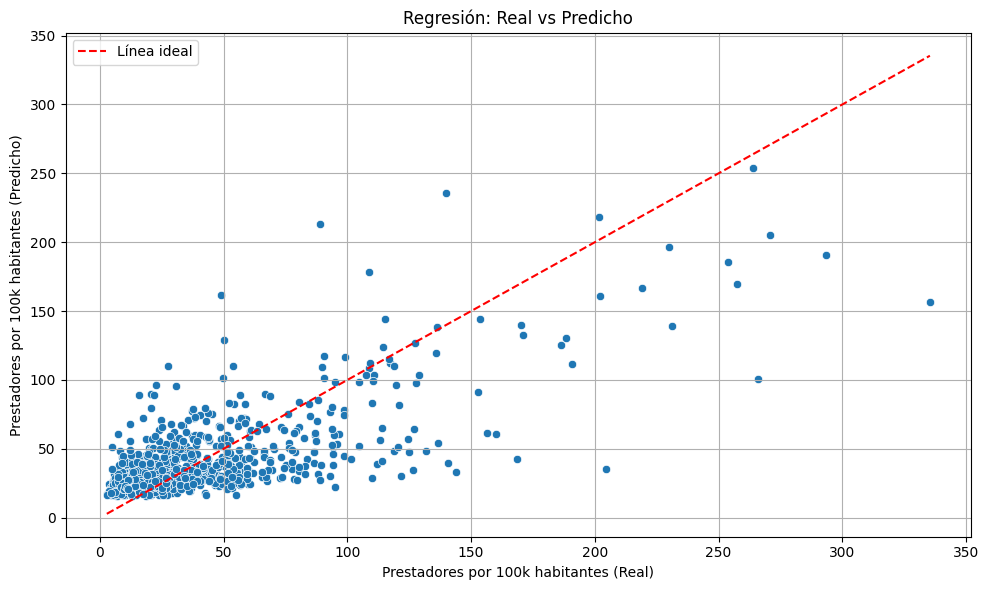

In [129]:
y_pred = model.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Línea ideal')
plt.xlabel("Prestadores por 100k habitantes (Real)")
plt.ylabel("Prestadores por 100k habitantes (Predicho)")
plt.title("Regresión: Real vs Predicho")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
indicadores.columns

Index(['depa_nombre', 'muni_nombre', 'num_prestadores', 'num_sedes',
       'sedes_complejidad_alta', 'sedes_complejidad_media',
       'sedes_ambulatorio', 'sedes_hospitalario', 'sedes_unidad_movil',
       'sedes_domiciliario', 'sedes_otras_extramural', 'cod_departamento',
       'departamento', 'cod_municipio', 'municipio', 'superficie_km2',
       'poblacion_total', 'porcentaje_ruralidad', 'region',
       'prestadores_por_100k', 'sedes_por_km2', 'alta_complejidad_por_100k',
       'media_complejidad_por_100k', 'ambulatorio_por_100k',
       'hospitalario_por_100k', 'unidad_movil_por_100k',
       'domiciliario_por_100k', 'otras_extramural_por_100k'],
      dtype='object')